In [1]:
import datetime
now = datetime.datetime.now()
print(now)

2021-06-13 14:52:06.278162


This notebook is in fulfillment of the **Exit Assessment** requirement for  **SP102: Designing and Building Data Products**, part of the Project SPARTA Learning Pathway.

Most of the code in this notebook has been taken from the sample notebook in Module 4.

## 🌟 Goal of this analysis

This analysis aims to build a model that will predict the median values of the owner-occupied homes.

The dependent variable of interest is `MEDV`. The input dataset is the **Boston Housing Dataset**, and the list of indepent variables are described below.

## Dataset

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston, Massachusetts. 

There are 14 attributes in each case of the dataset. They are:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- BLACK / B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's


## 💡 tl;dr

###  Summary 

This notebook covers the following steps of a machine learning pipeline:

- ✔ Exploratory data analysis (EDA)
- ✔ Spliting and training the data
- ✔ Spot checking algorithms
- ✔ Evaluating the algorithms
- ✔ Model training
- ✔ Model selection

This does not cover activities that require GCP:

- ❌ Model deployment
- ❌ Batch prediction

In building the model, the features `tax`, `black`, `dis`, `chas`, and `zn` where removed. This is a deviation from the original notebook, and was done to improve the accuracy of the model.

Lastly, a model was built to predict the prices using **XGBRegressor**, with some paramater tuning.

⭐ As a bonus, an explaination of the model using SHAP (SHapley Additive exPlanations) values has been included.

### 🎓 Conclusion

Model spotting resulted in **XGBoost** as the best model to use among those tested.

A model was subsequently trained with some parameter tuning, and has the following characteristics:

```
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
```
and score:

```
MAE: 0.037
MSE: 0.003 
RMSE: 0.054
R2: 0.88
```

Of the features, `rm` (average number of rooms per dwelling) and `lstat` (% lower status of the population) have the highest importance in predicting the median values of the houses. 


- As the number of rooms in the house increase, so does the house prices.
- As the percentage of the lower status of the population increase, the house prices decrease.

Other interesting interactions were observed, for example

- In the plot of `crim` vs `lstat`, criminal activities has a positive interaction with the lower status of the population, higher values of both affect the values of housing negatively.
- In the plot of `rm` vs `nox`, house with higher number of rooms tend to have lower amounts of nitric oxide while
- In the plot of `age` vs `nox`, higher levels of nitric oxide can be seen in properties built in areas with 80% or more units built prior to 1940.
- Lastly, in the plot `rad` vs `nox`, while radial access to highways does not dramatically affect the prices of houses, those with higher access (higher `rad` values), tend to also report a disproportional amounts of nitric oxide.

## Recommendation
Since this analysis was carried out in my local machine, I limited tuning into a few parameters. Further hyperparamater tuning can be carried out to build a more accurate model, or test more algorithms. The Google Cloud MLE offers a more sophisticated environment to carry out model building for this dataset.

--

## Exploratory Data Analys

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Initial observation of the dataframe shows that the first column of the dataset can be safely dropped.

In [3]:
boston_housing_df = pd.read_csv('Boston.csv').iloc[: , 1:]

In [4]:
boston_housing_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
boston_housing_df.tail()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


In [6]:
boston_housing_df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
boston_housing_df.shape

(506, 14)

In [8]:
boston_housing_df.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In the dataset description, `chas` is actually boolean. In this analysis, this distinction does not matter.

## Visualization

Plotting the prices shows that the values generally follow a normal distribution.

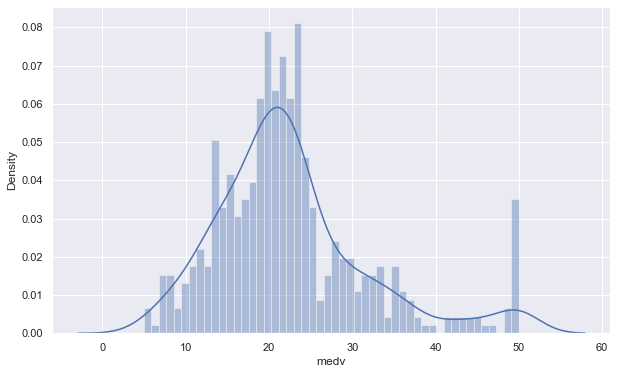

In [9]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.distplot((boston_housing_df['medv']),bins=50)

## Correlation and multicolinearity

To determine which variables can be best incorporated in the model, a correlation matrix can be computed. A correlation matrix shows the degree of dependence of each variable with one another.

Values close to 0 mean total independence, while values closer to 1 and -1, show positive and negative  dependence. Values given are Pearson coefficients (default of `pandas.corr()`).

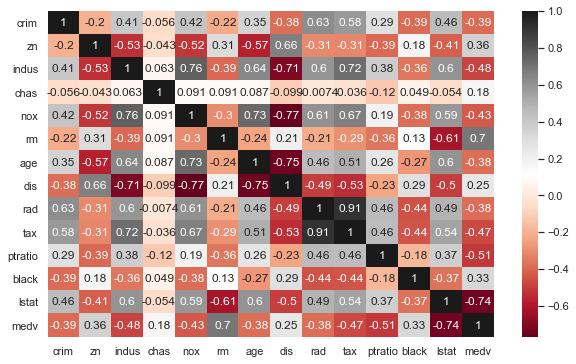

In [10]:
sns.heatmap(boston_housing_df.corr(), cmap = 'RdGy',annot=True)

From the correlation matrix above, the following variables show little correlation with `medv` (colors tend towards white): 
- `black`
- `dis`
- `chas`
- `zn`

To determine the best variables to incorporate in the model, it is also important to know which variables are strongly correlated with one another. Multicollinearity occurs when there are variables that are related to the dependent variable, as well as to other variables. In corporating such data affects the accuracy of the model; therefore, these variables should be avoided when building the model

In [11]:
import pandas_profiling

In [12]:
profile_result = pandas_profiling.ProfileReport(boston_housing_df)

In [13]:
profile_result

Number of variables,14
Number of observations,506
Total Missing (%),0.0%
Total size in memory,55.4 KiB
Average record size in memory,112.2 B
Numeric,12
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


Profiling shows that the `tax` variable is strongly correlated with `rad` variable.

## Data pre-processing

### Remove features

Remove the features that will likely negatively affect the model

In [14]:
# get rejected features
rejected_vars = profile_result.get_rejected_variables()

# also add the features that are least correlated with `medv` to the list of rejected features
rejected_vars.extend(['black', 'dis', 'chas', 'zn'])

# drop the features
boston_housing_df.drop(rejected_vars, axis=1, inplace=True)

### Scale and normalize features

Feature scaling brings the values to a common scale. This is specially important when building regression models. Extremely large values tend to affect the model more even if they're not necessarily more important to the model.

In [15]:
# scale the dataframe values
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import Normalizer

Scale the values to a range of 0 to 1, then rescale so that the norm (l2, default) of the samples equals to one.

In [16]:
dataset = pd.DataFrame(minmax_scale(boston_housing_df), columns=boston_housing_df.columns)
dataset = pd.DataFrame(Normalizer().fit(dataset).transform(dataset), columns=dataset.columns)

Visualizing the distribution should show that the distribution of values does not deviate from the original values.

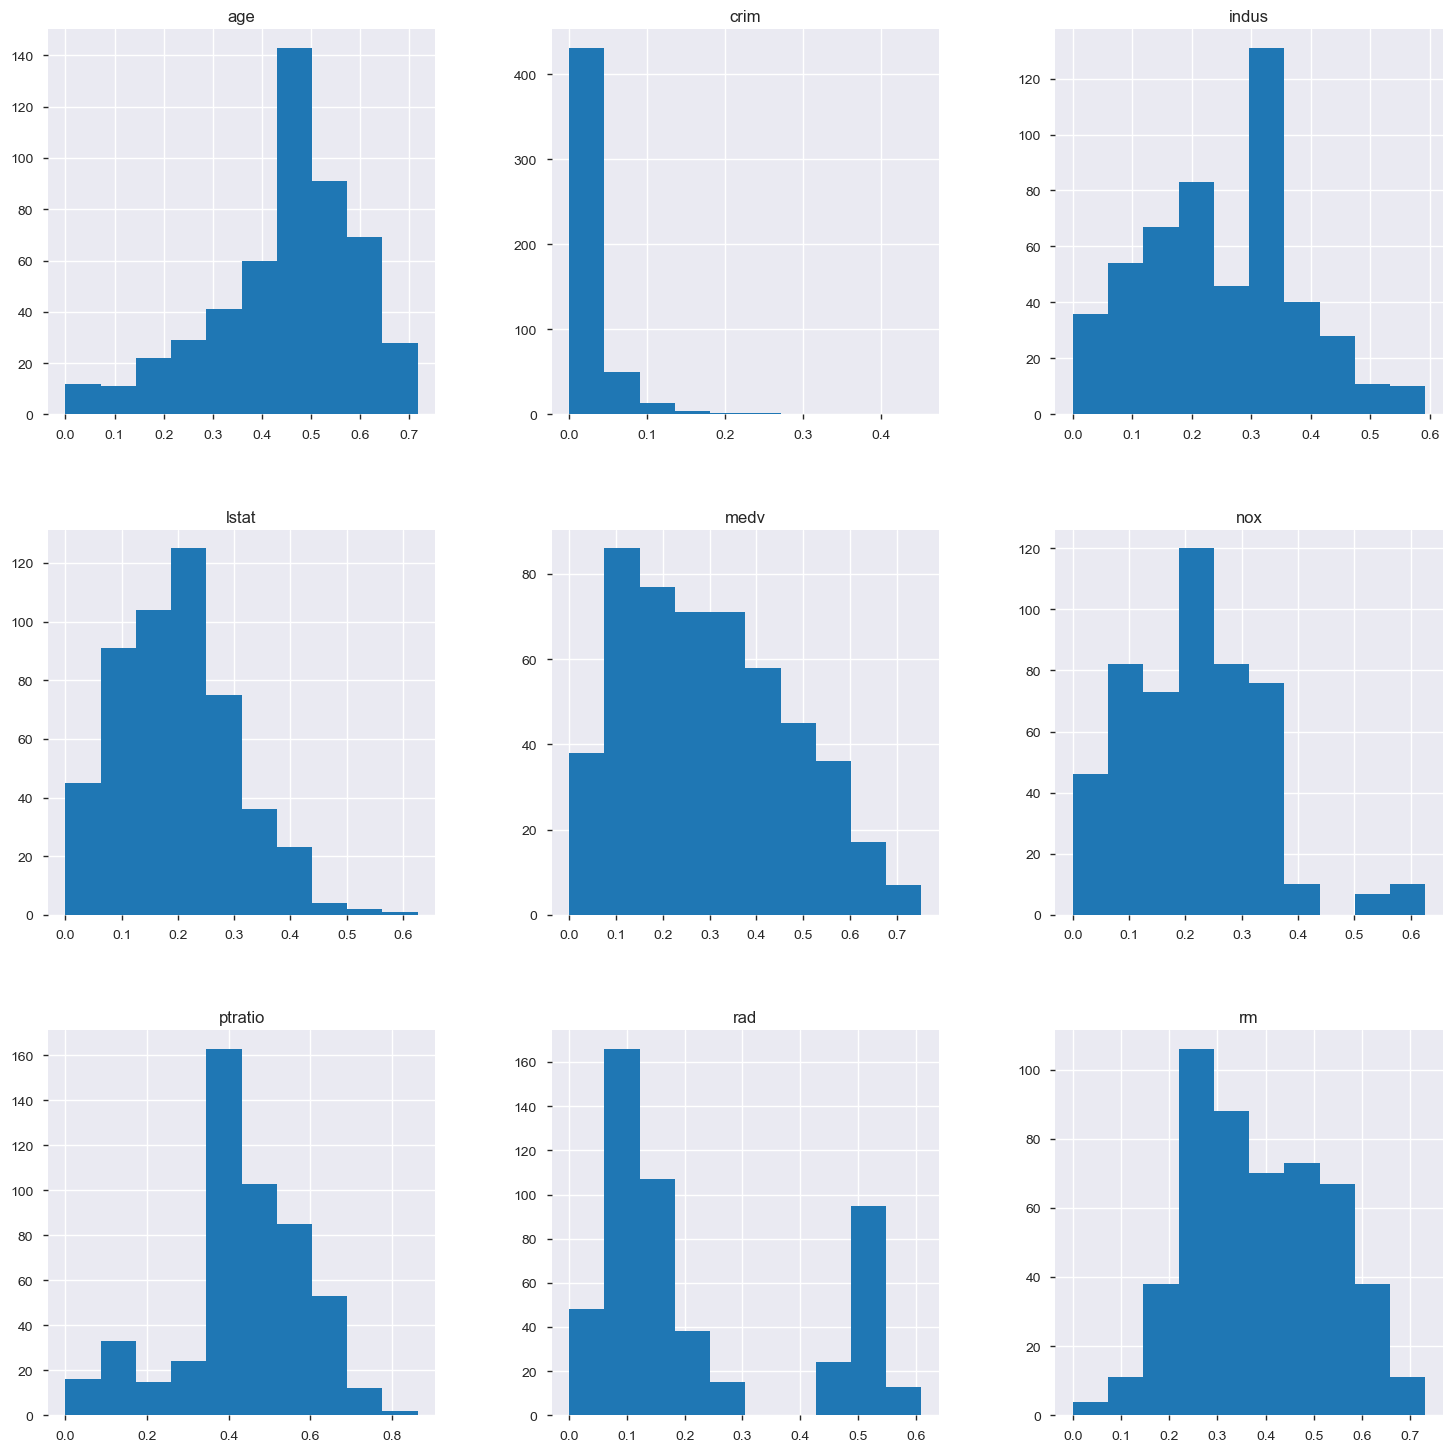

In [17]:
dataset.hist(figsize=(18,18))
plt.show()

## Spot Checking Machine Learning Algorithms

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from math import sqrt

Spot-checking involves rougly evaluating a set of machine learning algorithms to provide a priliminary evaluation.

Split the data into features (independent variables) and labels (dependent variable). Further split each of these into train and test sets.

(I added `random=42` so I can get the same results every time I re-run the analysis, but this optional.)

In [19]:
dataset_y = dataset['medv']
dataset_X = dataset.drop(['medv'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, shuffle=True, random_state=42)

For each algorithm, train with the training set and evaluate on the hold-out test set

In [20]:
# a dictionary of the candidate algorithms
ml_models = {
    'Linear Reg.': LinearRegression(),
    'Dec. Trees': DecisionTreeRegressor(),
    'Rand. Forest': RandomForestRegressor(),
    'SVM': SVR(),
    'XGBoost': XGBRegressor(),
    'NNets': MLPRegressor(warm_start=True, early_stopping=True, learning_rate='adaptive')
}
ml_results = {}

for name, model in ml_models.items():
    # fit model on training data
    model.fit(X_train, y_train)
    # make predictions for test data
    prediction = model.predict(X_test)
    # evaluate predictions
    rmse = sqrt(metrics.mean_squared_error(y_test, prediction))
    # append accuracy results to dictionary
    ml_results[name] = rmse
    print('RMSE: {} -> {}'.format(name, rmse))

RMSE: Linear Reg. -> 0.05073197937173562
RMSE: Dec. Trees -> 0.06453921244335604
RMSE: Rand. Forest -> 0.048999282045499075
RMSE: SVM -> 0.057511403086426355
RMSE: XGBoost -> 0.042882498035871734
RMSE: NNets -> 0.04933468714957404


Root-mean-square error (RMSE) measures the differences between values predicted by a model and the values observed.

This evaluation shows that XGBoost has the least measured errors.

Text(0, 0.5, 'RMSE')

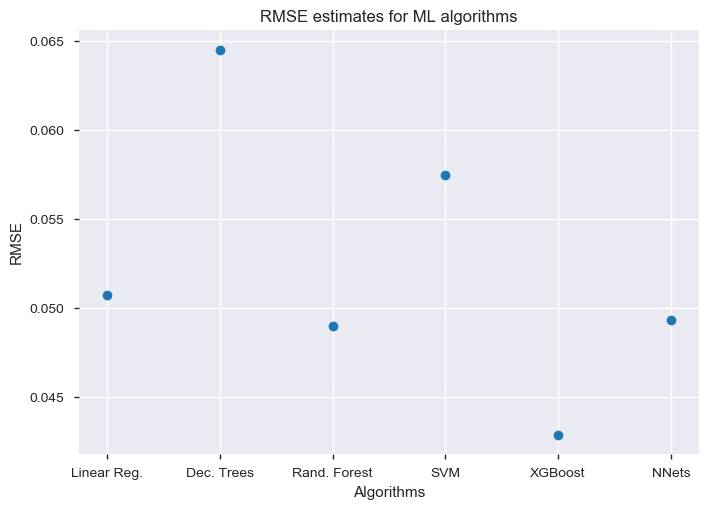

In [21]:
plt.plot(list(ml_results.keys()), list(ml_results.values()), 'o')
plt.title("RMSE estimates for ML algorithms")
plt.xlabel('Algorithms')
plt.ylabel('RMSE')

## A model to predict the price using XGBoost

In [22]:
from sklearn.model_selection import GridSearchCV
import numpy as np

### What is XGBoost

> XGBoost (“Extreme Gradient Boosting”) is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples. - [XGBoost ReadTheDocs](https://xgboost.readthedocs.io/en/latest/)

### Split the dataset into training, validation, and test set

The pre-processed dataset is split into three:

- training dataset (60%), used to train the model
- validation dataset (20%), used to select the best model 
- test dataset (20%), data used to provide an unbiased evaluation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Train and evaluate combinations of model parameters

The model is created and trained, and some hyperparameter tuning is done.

In [24]:
regr = XGBRegressor()
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None],
}

cv = GridSearchCV(regr, parameters, cv=5)
cv.fit(X_train, y_train)

C:\Users\Marylette\Anaconda3\envs\mglearn\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constrain...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree

In [25]:
means = cv.cv_results_['mean_test_score']
stds = cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv.cv_results_['params']):
    print(f"{round(mean, 3)} +/-{round(std * 2, 3)} for {params}")
print(f"best parameter : {cv.best_params_}\n")

0.74 +/-0.069 for {'max_depth': 2, 'n_estimators': 5}
0.874 +/-0.068 for {'max_depth': 2, 'n_estimators': 50}
0.878 +/-0.076 for {'max_depth': 2, 'n_estimators': 100}
0.764 +/-0.098 for {'max_depth': 10, 'n_estimators': 5}
0.849 +/-0.069 for {'max_depth': 10, 'n_estimators': 50}
0.849 +/-0.069 for {'max_depth': 10, 'n_estimators': 100}
0.763 +/-0.1 for {'max_depth': 20, 'n_estimators': 5}
0.848 +/-0.072 for {'max_depth': 20, 'n_estimators': 50}
0.848 +/-0.072 for {'max_depth': 20, 'n_estimators': 100}
0.776 +/-0.089 for {'max_depth': None, 'n_estimators': 5}
0.869 +/-0.071 for {'max_depth': None, 'n_estimators': 50}
0.869 +/-0.072 for {'max_depth': None, 'n_estimators': 100}
best parameter : {'max_depth': 2, 'n_estimators': 100}



Therefore, the top 3 scoring parameters are:

```
0.878 +/-0.076 for {'max_depth': 2, 'n_estimators': 100}
0.874 +/-0.068 for {'max_depth': 2, 'n_estimators': 50}
0.849 +/-0.069 for {'max_depth': 10, 'n_estimators': 100}
```

## Evaluate the top 3 scoring models on the training set

The top three models are re-trainined using the entire training set

In [26]:
regr1 = XGBRegressor(max_depth=2, n_estimators=100)
regr1.fit(X_train, y_train)

regr2 = XGBRegressor(max_depth=2, n_estimators=50)
regr2.fit(X_train, y_train)

regr3 = XGBRegressor(max_depth=10, n_estimators=100)
regr3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Then evaluated the on validation set

The following metrics assess the accuracy of the model:

- MAE (mean absolute error), the absolute difference between actual and predicted values.
- MSE (mean squared error), the absolute difference between actual and predicted values.
- RMSE (root mean squared error), square root of mean squared error
- R^2 (R squared), aka Goodness of fit, measurement of fit to a regression line, 0 worst - 1 perfect fit

In [27]:
for mdl in [regr1, regr2, regr3]:
    y_pred_val = mdl.predict(X_val)
    mae = round(metrics.mean_absolute_error(y_val, y_pred_val), 3)
    mse = round(metrics.mean_squared_error(y_val, y_pred_val), 3)
    rmse = round(sqrt(metrics.mean_squared_error(y_val, y_pred_val)), 3)
    r2 = round(metrics.r2_score(y_val, y_pred_val), 3)
    print(f"max depth: {mdl.max_depth} / # of estimators: {mdl.n_estimators}: MAE: {mae};  MSE: {mse};  RMSE: {rmse}; R2: {r2}")

max depth: 2 / # of estimators: 100: MAE: 0.04;  MSE: 0.003;  RMSE: 0.054; R2: 0.903
max depth: 2 / # of estimators: 50: MAE: 0.041;  MSE: 0.003;  RMSE: 0.055; R2: 0.899
max depth: 10 / # of estimators: 100: MAE: 0.035;  MSE: 0.002;  RMSE: 0.046; R2: 0.93


From this evaluation, model `regr3` has the least error. The final evaluation is done using the `test` set.

## Evaluate the best model on the test set

This will give an unbiased evaluation of the model, representing data that has not been seen during the model evaluation stages.

In [28]:
y_pred_test = regr3.predict(X_test)
mae = round(metrics.mean_absolute_error(y_test, y_pred_test), 3)
mse = round(metrics.mean_squared_error(y_test, y_pred_test), 3)
rmse = round(sqrt(metrics.mean_squared_error(y_test, y_pred_test)), 3)
r2 = round(metrics.r2_score(y_test, y_pred_test), 3)
print(f"MAX DEPTH: {mdl.max_depth} / # OF EST: {mdl.n_estimators} -- MAE: {mae} / MSE: {mse} / RMSE: {rmse} / R2: {r2}")

MAX DEPTH: 10 / # OF EST: 100 -- MAE: 0.037 / MSE: 0.003 / RMSE: 0.054 / R2: 0.88


Comparisons between the actual prices and the predicted prices indicate the values has a tight spread around the diagonal.

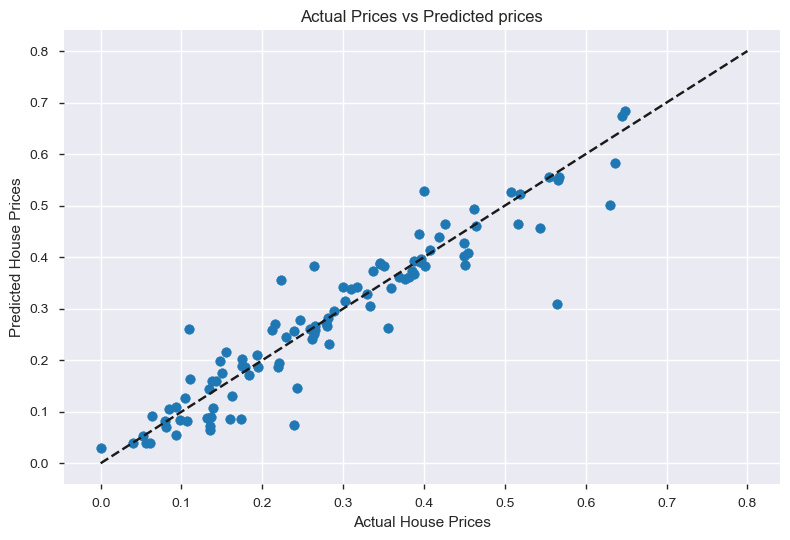

In [29]:
plt.scatter(y_test, y_pred_test)
plt.plot([0, .8], [0, .8], '--k')
plt.axis('tight')
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual Prices vs Predicted prices")
plt.tight_layout()

## Summary and conclusion

This notebook covers the following steps of a machine learning pipeline:

- ✔ Exploratory data analysis (EDA)
- ✔ Spliting and training the data
- ✔ Spot checking algorithms
- ✔ Evaluating the algorithms
- ✔ Model training
- ✔ Model selection

In building the model, the features `tax`, `black`, `dis`, `chas`, and `zn` where removed.  

Model spotting show that the best model to use is XGBoost.

A model was trained with some parameter tuning, and has the following characteristics:

```
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
```

--

## 🥔 Model interpretation

Reference: [Interpretable Machine Learning with XGBoost by Scott Lundberg](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

In [30]:
from xgboost import plot_importance
import shap

From the mean SHAP values, the most important feature is `rm` (*average number of rooms per dwelling*), followed by `lstat` (% lower status of the population).

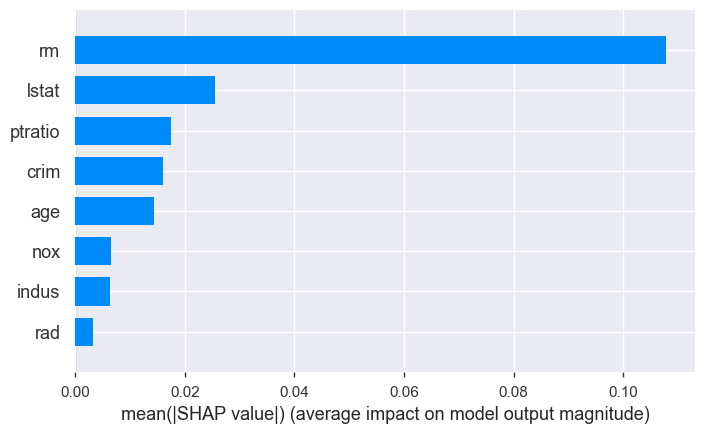

In [31]:
explainer = shap.TreeExplainer(regr3)
shap_values = explainer.shap_values(dataset_X)
shap.summary_plot(shap_values, dataset_X, plot_type="bar")

The feature importane for every data point is given below. Some of the observations that can be gleaned from the plot are the following:

- As the number of rooms in the house increase, so does the house prices.
- As the percentage of the lower status of the population increase, the house prices decrease.

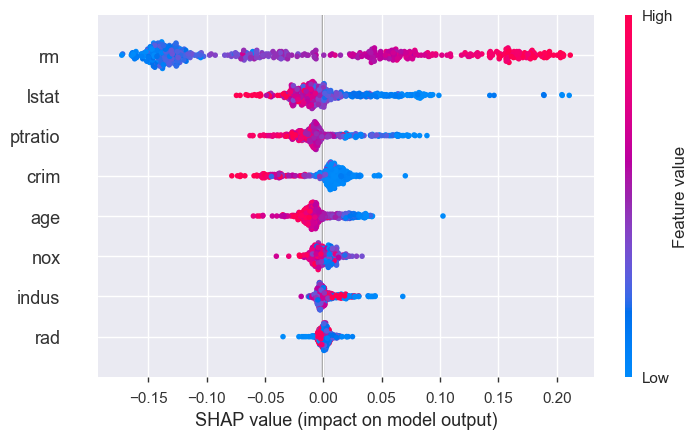

In [32]:
shap.summary_plot(shap_values, dataset_X)

The following SHAP dependence plots show the interaction effects present in the features, including effects of a possible interaction. For example:

- In the plot of `crim` vs `lstat`, criminal activities has a positive interaction with the lower status of the population, higher values of both affect the values of housing negatively.
- In the plot of `rm` vs `nox`, house with higher number of rooms tend to have lower amounts of nitric oxide while
- In the plot of `age` vs `nox`, higher levels of nitric oxide can be seen in properties built in areas with 80% or more units built prior to 1940.
- Lastly, in the plot `rad` vs `nox`, while radial access to highways does not dramatically affect the prices of houses, those with higher access (higher `rad` values), tend to also report a disproportional amounts of nitric oxide.

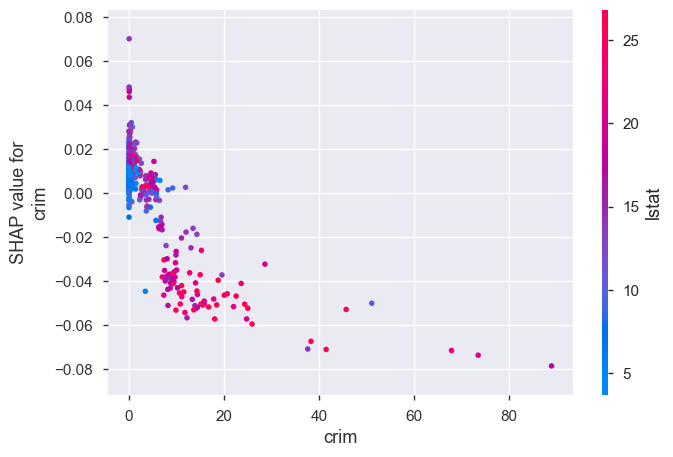

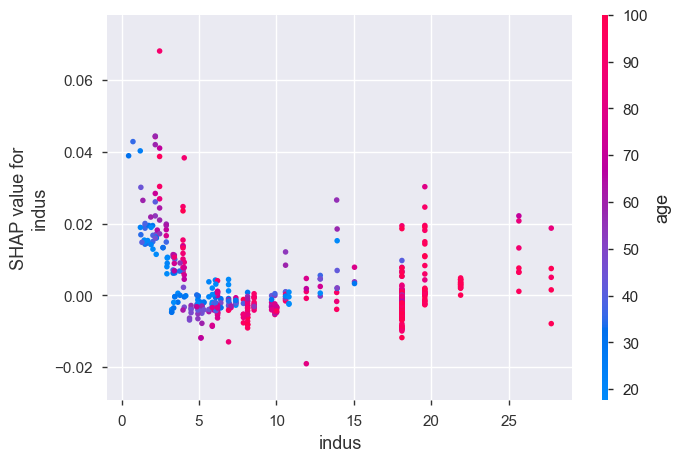

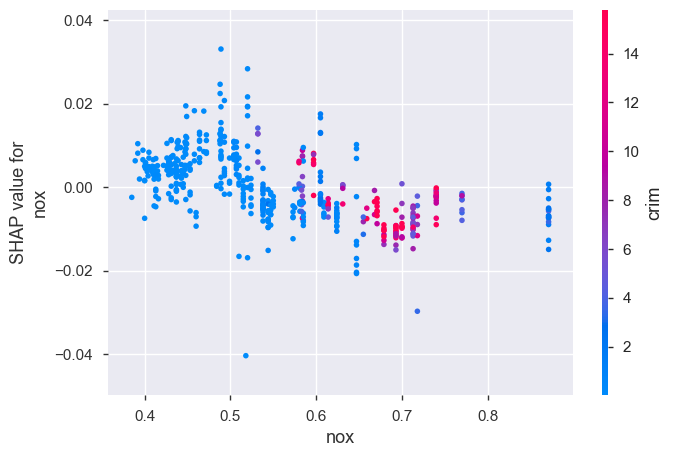

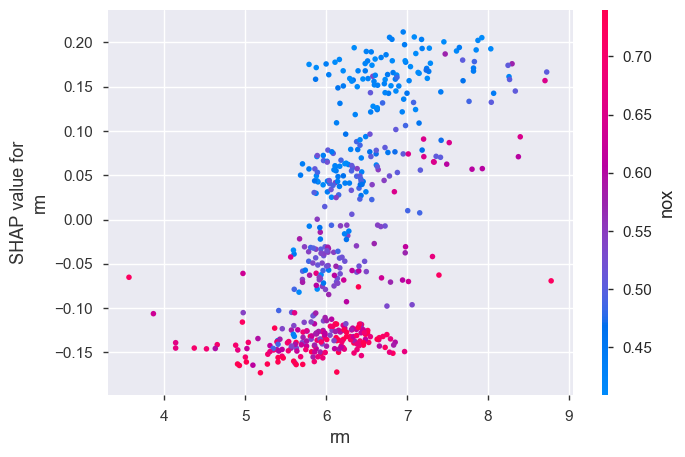

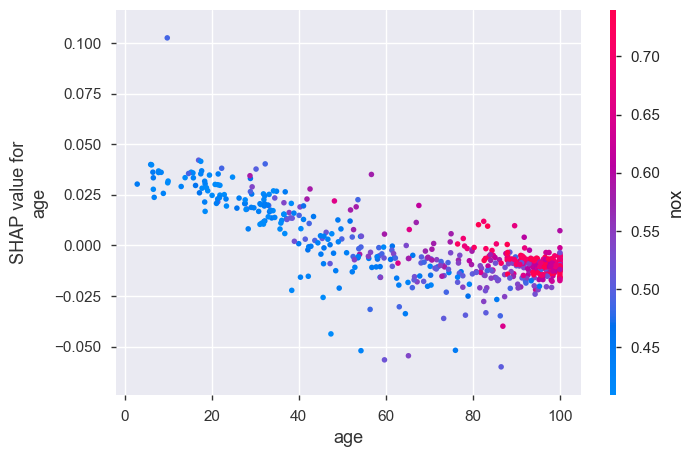

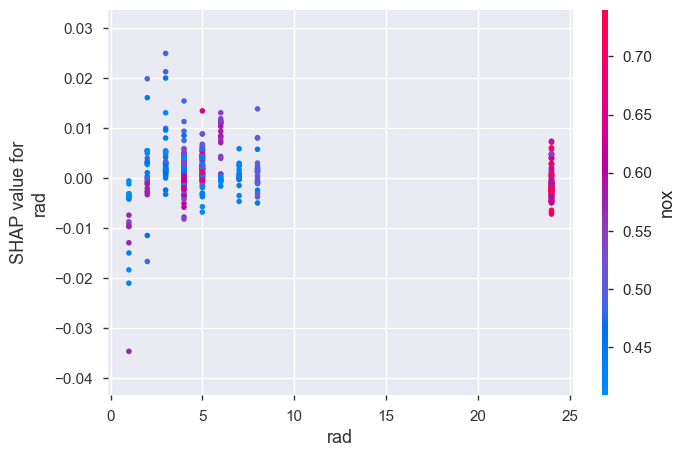

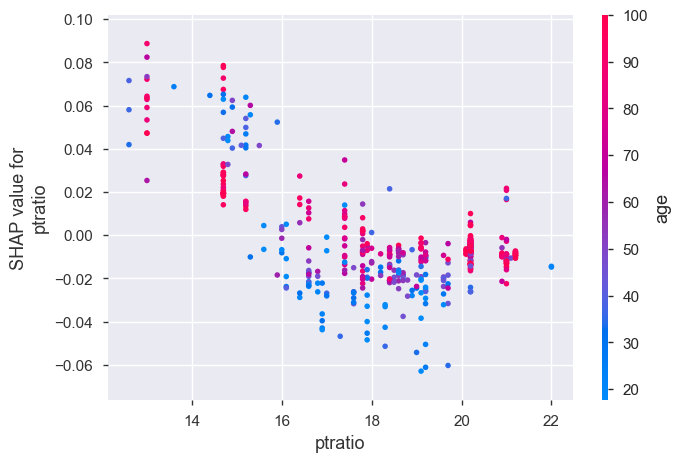

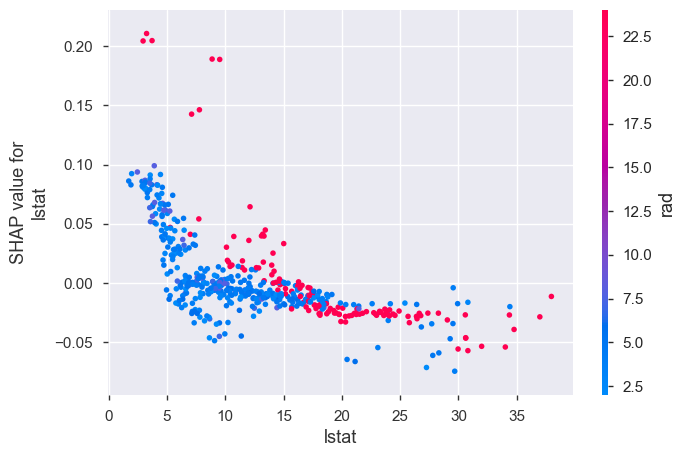

In [33]:
X = boston_housing_df.drop(['medv'], axis=1)
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)